In [1]:
import numpy as np
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm

In [51]:
class explorationOptimizer:
    def getEpsilon(epsilon_initial=0.85, epsilon_final=0.05, current_epoch=0, num_epochs=1000):
        # pct_of_way = current_epoch / num_epochs
        return epsilon_initial - (epsilon_initial - epsilon_final) * (current_epoch / num_epochs)

In [52]:
explorationOptimizer.getEpsilon(0.85, 0.05, 500, 1000)

0.45

In [69]:
class Agent:
    def __init__(self, k=3, num_epochs=100, num_iters=10000, explorationOptimizer=explorationOptimizer, epsilon_initial=0.85, epsilon_final=0.05):
        self.k = k # Number of arms
        self.num_epochs = num_epochs # Number of times to run
        self.num_iters = num_iters # Number of times to select a value before updating the policy
        self.bandits = np.random.rand(k) # Probability of success for each arm, sample from a gaussian distribution centered around the mean
#         self.bandits = np.array([0.10, 0.12, 0.11, 0.13, 0.14, 0.11, 0.12, 0.09, 0.13, 0.10])
        # self.bandits = np.array([0.10, 0.50, 0.60, 0.80, 0.10, 0.25, 0.60, 0.45, 0.75, 0.65])
        self.explorationOptimizer = explorationOptimizer
        self.epsilon_initial = epsilon_initial
        self.epsilon_final = epsilon_final
        self.Q = [(1, self.get_reward(i)) for i in range(k)]
        self.avg_step_rewards = []            
        
    def get_reward(self, selection_idx):
        return int(np.random.uniform() <= self.bandits[selection_idx])
    
    def take_step(self, curr_epoch):
        thresholds = np.random.uniform(size=(self.num_iters))
        greedy = (np.random.uniform(size=(self.num_iters)) >= self.explorationOptimizer.getEpsilon(self.epsilon_initial, self.epsilon_final, curr_epoch, self.num_epochs)).astype(bool)
        avg_max_arm = 0
        max_arm_idx = 0
        
        avg_rewards = [np.average(i[1]) for i in self.Q]
        max_arm_idx = np.argmax(avg_rewards)

        step_rewards = []
        
        for i in range(self.num_iters):
            if (greedy[i]):
                step_rewards.append((max_arm_idx, self.get_reward(max_arm_idx)))
            else:
                arm_idx = np.random.randint(0, self.k)
                step_rewards.append((arm_idx, self.get_reward(arm_idx)))

        for reward in step_rewards:
            # Incremental update
            self.Q[reward[0]] = (self.Q[reward[0]][0] + 1, self.Q[reward[0]][1] + 1 / self.Q[reward[0]][0] * (reward[1] - self.Q[reward[0]][1]))
        
        return np.average([r[1] for r in step_rewards])
    
    def run(self):
        for epoch in tqdm(range(self.num_epochs)):
            self.avg_step_rewards.append(self.take_step(epoch))
        
        max_idx = np.argmax([r[0] for r in self.Q])
        print(self.Q[max_idx][1])
        print("Max val ", self.Q[max_idx][1] ," at idx ", max_idx)

In [74]:
a = Agent(k=3, num_epochs=1000, num_iters=1000, explorationOptimizer=explorationOptimizer)
max_mean_idx = np.argmax(a.bandits)
print(a.bandits)
print("Max val ", a.bandits[max_mean_idx] ," at idx ", max_mean_idx)
print(a.explorationOptimizer.getEpsilon())

[0.99477625 0.32269257 0.61532172]
Max val  0.994776249366923  at idx  0
0.85


In [75]:
a.run()

100%|██████████| 1000/1000 [00:05<00:00, 189.17it/s]

0.9946623996342538
Max val  0.9946623996342538  at idx  0


In [76]:
print([r[0] for r in a.Q])
print([r[1] for r in a.Q])

[699941, 149988, 150074]
[0.9946623996342538, 0.3192476681312324, 0.6135680635424111]


<AxesSubplot:>

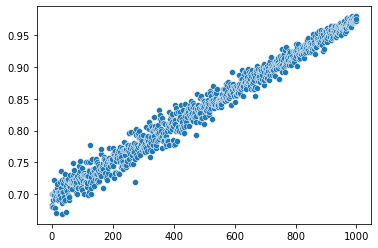

In [77]:
sns.scatterplot(x=[i for i in range(len(a.avg_step_rewards))], y=a.avg_step_rewards)